## Information Retrieval lab6

- Martyna Stasiak id.156071
- Maria Musiał id.156062
----

In [91]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
import ast
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
from scipy.stats import chi2_contingency

You shall already be familiar with the concept of association rules and the apriori algorithm. Association rule mining is a method for discovering patterns within large data sets. It focuses on identifying relationships between variables and leveraging those connections to make predictions or informed decisions. The primary objective is to uncover rules that reveal the associations between various items in the data.



### Task 1
Load data from data.txt file - it contains lists of grocery shopping done by nearly 2000 customers.
Store it in a boolean one hot encoded dataframe - True for items bought in a given transaction, False otherwise.

In [92]:
with open('data.txt', 'r') as file:
    lines = file.readlines()
    
transactions = [ast.literal_eval(line.strip()) for line in lines]

unique_items = sorted(set(item for transaction in transactions for item in transaction))
print(f"There are {len(transactions)} transactoins.")
print(f"There are {len(unique_items)} unique items.")
print(f"And those are:")
print(unique_items)

There are 1916 transactoins.
There are 18 unique items.
And those are:
['apple', 'banana', 'beef', 'bread', 'butter', 'cheese', 'chicken', 'chocolate', 'eggs', 'grill', 'ketchup', 'milk', 'mustard', 'orange', 'pork', 'sausage', 'wagyu', 'yogurt']


In [93]:
#create a dataframe where each row is a transaction and each column is an item
basketdf = pd.DataFrame([{item: item in transaction for item in unique_items} for transaction in transactions]) 
basketdf = basketdf.astype(bool) #converting to T/F

print(f"The number of rows in the basket dataframe is {basketdf.shape[0]}")
print(f"The number of columns in the basket dataframe is {basketdf.shape[1]}")
print(f"Here is the basket dataframe:")
basketdf.head()

The number of rows in the basket dataframe is 1916
The number of columns in the basket dataframe is 18
Here is the basket dataframe:


,apple,banana,beef,bread,butter,cheese,chicken,chocolate,eggs,grill,ketchup,milk,mustard,orange,pork,sausage,wagyu,yogurt
0,True,True,False,False,False,False,True,True,False,False,False,True,False,True,False,False,False,False
1,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True
2,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False
4,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


To extract rules you can use e.g. apriori algorithm implemented in mlxtend. There are other algorithms performing the same task but using different approaches e.g. fpgrowth internally uses a tree-based structure which makes it faster in most real-life examples.

----

### Task 2
Find association rules using selected algorithm

### `Apriori`

First we have used the apriori algorithm using `apriori` function fom `mlxtend.frequent_patterns` library, with minimal supprt of 0.1 meaning that the itemset (containing at least 1 item or more)  has to appear in at least of 10% of the transaction. From this we got 19 frequent itemsets.<br>
Then we chose the minimal confidence of 0.5 meaning that for a rule *X → Y* at least 50% of the transactions containing item *X* also contained *Y*. Next we have used the `association_rules` function from the same library to get the association rules. This allowed us to get the frequent but also reliable association rules.<br>
After extracting the rules we have analized them and visualized them on the two types of plots.
-  Heatmap of Lift - it represets the lift values of the association rules, where the antecedents (so the *X* part of the rule) are shown on the y-axis and the consequents (the *Y* part of the rule) on the x-axis. Each cell represents the lift of a particular rule. Lift values greater than 1 indicate a strong positive correlation, while values close to 1 suggest independence between the antecedent and consequent.
- Network Graph - represents the association rules as a directed graph. Each node corresponds to an item or itemset, and the edges represent the rules *X → Y*, with the direction indicating the association. The edge labels display the lift values of the rules<br>


The rule that had the highest lift and other metrics was `grill → sausage`, which makes a lot of sense since they are oftey bought by the people together since they are used together for barbecues and geilling.

In [94]:
minSup = 0.1 #iteset has to appear in at least 10% of the transactions
frequent_itemsets = apriori(basketdf, min_support=minSup, use_colnames=True)
print(f"Number of frequent itemsets with min support of {minSup} is {frequent_itemsets.shape[0]}")
print(f"Here are the frequent itemsets:")
print(frequent_itemsets)


Number of frequent itemsets with min support of 0.1 is 19
Here are the frequent itemsets:
     support            itemsets
0   0.151879             (apple)
1   0.165449            (banana)
2   0.127871              (beef)
3   0.253653             (bread)
4   0.212422            (cheese)
5   0.420668           (chicken)
6   0.179541         (chocolate)
7   0.113257             (grill)
8   0.400313              (milk)
9   0.162317            (orange)
10  0.205115              (pork)
11  0.248434           (sausage)
12  0.237474            (yogurt)
13  0.104384    (bread, chicken)
14  0.149791     (chicken, milk)
15  0.102296  (chicken, sausage)
16  0.122651   (chocolate, milk)
17  0.105428    (grill, sausage)
18  0.129436      (yogurt, milk)


In [95]:
minConf = 0.5 
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=minConf)
print(f"Number of rules with min confidence of {minConf} is {rules.shape[0]}")
print(f"The achieved rules:")
rules.sort_values(by='confidence', ascending=False)

Number of rules with min confidence of 0.5 is 3
The achieved rules:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
1,(grill),(sausage),0.113257,0.248434,0.105428,0.930876,3.746970,0.077291,10.872651,0.826753
0,(chocolate),(milk),0.179541,0.400313,0.122651,0.683140,1.706513,0.050779,1.892590,0.504607
2,(yogurt),(milk),0.237474,0.400313,0.129436,0.545055,1.361571,0.034372,1.318152,0.348256


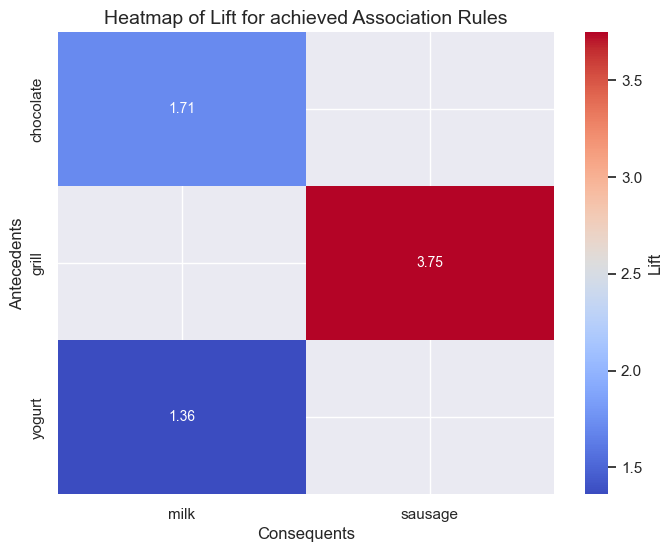

In [96]:
import seaborn as sns

# preparing data for heatmap
rules['antecedents'] = rules['antecedents'].apply(lambda x: ''.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ''.join(list(x)))
rules_heatmap = rules.pivot(index='antecedents', columns='consequents', values='lift')

# Adjust figure size
plt.figure(figsize=(8, 6))

# heatmap
sns.set(font_scale=1.0)  
sns.heatmap(
    rules_heatmap,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={'label': 'Lift'},
    annot_kws={"fontsize": 10},  
)

plt.title('Heatmap of Lift for achieved Association Rules', fontsize=14)
plt.xlabel('Consequents', fontsize=12)
plt.ylabel('Antecedents', fontsize=12)

# Show plot
plt.show()


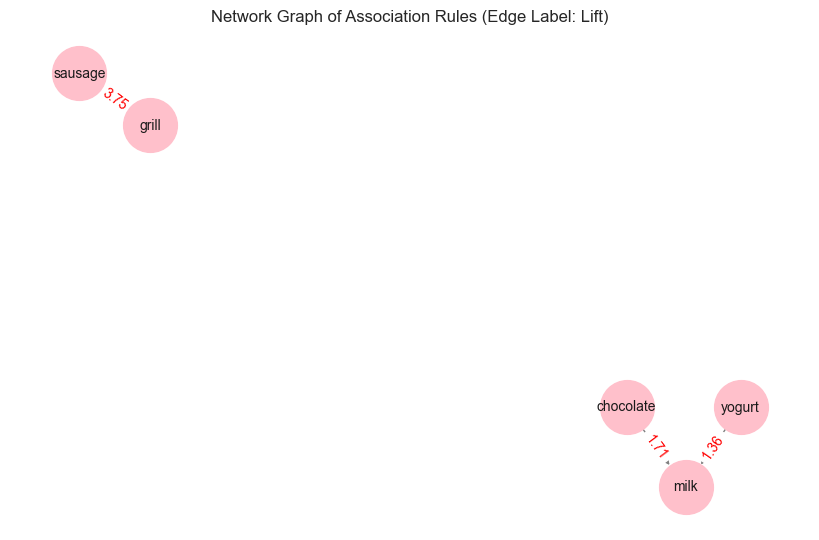

In [97]:
#directed graph
G = nx.DiGraph()
# adding edges for each rule
for i, rule in rules.iterrows():
    G.add_edge(''.join(list(rule['antecedents'])), ''.join(list(rule['consequents'])), weight=rule['lift'])


plt.figure(figsize=(8, 5))
pos = nx.spring_layout(G, k=0.5, seed=42)  # Positioning of nodes
nx.draw(G, pos, with_labels=True, node_size=1500, node_color="pink", font_size=10, edge_color='gray')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()}, font_color='red')
plt.title('Network Graph of Association Rules (Edge Label: Lift)')
plt.show()


### `FP-Growth`

Next we have tested the `FP-Growth` algorithm, by following the same steps as in the `apriori` from above but we got the exact same results in the form of rules. <br>
And extracted `rules_fp` is the same as `rules` because the `fpgrowth` algorithm is equivalent to the `apriori` algorithm in this case.

In [98]:
minSup = 0.1 #iteset has to appear in at least 10% of the transactions
frequent_itemsets_fp = fpgrowth(basketdf, min_support=minSup, use_colnames=True)
print(f"Number of frequent itemsets with min support of {minSup} is {frequent_itemsets_fp.shape[0]}")
print(f"Here are the frequent itemsets:")
print(frequent_itemsets_fp)

Number of frequent itemsets with min support of 0.1 is 19
Here are the frequent itemsets:
     support            itemsets
0   0.420668           (chicken)
1   0.400313              (milk)
2   0.179541         (chocolate)
3   0.165449            (banana)
4   0.162317            (orange)
5   0.151879             (apple)
6   0.237474            (yogurt)
7   0.212422            (cheese)
8   0.205115              (pork)
9   0.248434           (sausage)
10  0.127871              (beef)
11  0.253653             (bread)
12  0.113257             (grill)
13  0.149791     (chicken, milk)
14  0.122651   (chocolate, milk)
15  0.129436      (yogurt, milk)
16  0.102296  (chicken, sausage)
17  0.104384    (bread, chicken)
18  0.105428    (grill, sausage)


In [99]:
minConf = 0.5 
rules_fp = association_rules(frequent_itemsets_fp, metric="confidence", min_threshold=minConf)
print(f"Number of rules with min confidence of {minConf} is {rules_fp.shape[0]}")
print(f"The achieved rules:")
rules_fp.sort_values(by='confidence', ascending=False)

Number of rules with min confidence of 0.5 is 3
The achieved rules:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2,(grill),(sausage),0.113257,0.248434,0.105428,0.930876,3.746970,0.077291,10.872651,0.826753
0,(chocolate),(milk),0.179541,0.400313,0.122651,0.683140,1.706513,0.050779,1.892590,0.504607
1,(yogurt),(milk),0.237474,0.400313,0.129436,0.545055,1.361571,0.034372,1.318152,0.348256


----

### Task 3
The association rules are characterized by high support - frequency in the dataset. Can you use this algorithm as a base and try to extract different types of rules:
 - dissociation rules e.g. buying Porshe and Rolex is not frequent in the dataset, but usually people who bought Porshe also bought Rolex
 - negative rules e.g. if someone bought low-fat milk it's unlikely there will be whole milk in the basket
 - disjunction e.g. eggs and (kielecki xor winiary ;) )
 - imagine 50% of baskets have milk and 50% of baskets have tea. If there is no relation between them then in ~25% of baskets we will have both. If milk appears together with tea in e.g. 40% of baskets it means there is a pattern. Can you find such rules and use statistical tests to check if the relation is strong?

 Send the report within 144 hours starting from the end of this class to gmiebs@cs.put.poznan.pl; start this email's subject with [IR]


---

### 3.1) Dissociation rules
The dissociation rules uncover the patterns between itemsets that are not frequent but have the great probability of occuring together, just like when someone buys Porsche, it is quite probable that the person also bought Rolex but population wise those purchases are not so frequent.

First we follow the same steps as previosuly, but we change the parameters;<br>
First I have chosen the minimal support of 1% meaning that the itemset should appear in at least 1% of the transactions and that is wuite a drop from the previosly used 10% but thanks to this we may find the dissociation rules- items dont appear frequently but when they do, they do appear *almost* always together.

In [100]:
min_support_dissociation = 0.005  # itemset must appear in at least 0.5% of the baskets
frequent_itemsets_rare = apriori(basketdf, min_support=min_support_dissociation, use_colnames=True) # Generate frequent itemsets with a low support base to get dissociation rules

minConf = 0.9 # for rule x -> y, confidence must be at least 90% so that y is likely to be bought if x is bought
rules_rare = association_rules(frequent_itemsets_rare, metric="confidence", min_threshold=minConf)

rules_rare.sort_values(by='confidence', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
85,"(orange, ketchup, grill)",(sausage),0.007829,0.248434,0.007829,1.000000,4.025210,0.005884,inf,0.757496
91,"(mustard, milk, sausage)",(grill),0.022965,0.113257,0.022965,1.000000,8.829493,0.020364,inf,0.907585
123,"(banana, orange, ketchup, grill)",(sausage),0.005741,0.248434,0.005741,1.000000,4.025210,0.004315,inf,0.755906
122,"(orange, apple, ketchup, sausage)",(grill),0.005219,0.113257,0.005219,1.000000,8.829493,0.004628,inf,0.891396
121,"(orange, apple, ketchup, grill)",(sausage),0.005219,0.248434,0.005219,1.000000,4.025210,0.003923,inf,0.755509
...,...,...,...,...,...,...,...,...,...,...
106,"(banana, orange, apple, ketchup)",(grill),0.005741,0.113257,0.005219,0.909091,8.026812,0.004569,9.754175,0.880472
117,"(banana, apple, ketchup, sausage)",(orange),0.005741,0.162317,0.005219,0.909091,5.600702,0.004287,9.214509,0.826194
18,"(banana, apple, cheese)",(orange),0.010960,0.162317,0.009916,0.904762,5.574032,0.008137,8.795668,0.829690
45,"(bread, chocolate, cheese)",(milk),0.010960,0.400313,0.009916,0.904762,2.260135,0.005529,6.296712,0.563727


In [101]:
# Now we filter rules with low support but high confidence
dissociation_rules = rules_rare[(rules_rare['antecedent support'] < 0.02) & (rules_rare['consequent support'] < 0.02) & (rules_rare['confidence'] > 0.9)]
print("Dissociation Rules:")
print(f"Number of dissociation rules: {len(dissociation_rules)}")
dissociation_rules.sort_values(by='confidence', ascending=False)

Dissociation Rules:
Number of dissociation rules: 3


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
169,"(orange, apple, ketchup, sausage)","(banana, grill)",0.005219,0.019833,0.005219,1.000000,50.421053,0.005116,inf,0.985310
165,"(banana, apple, ketchup, sausage)","(orange, grill)",0.005741,0.017745,0.005219,0.909091,51.229947,0.005117,10.804802,0.986142
167,"(banana, orange, ketchup, sausage)","(apple, grill)",0.005741,0.013570,0.005219,0.909091,66.993007,0.005141,10.850731,0.990761


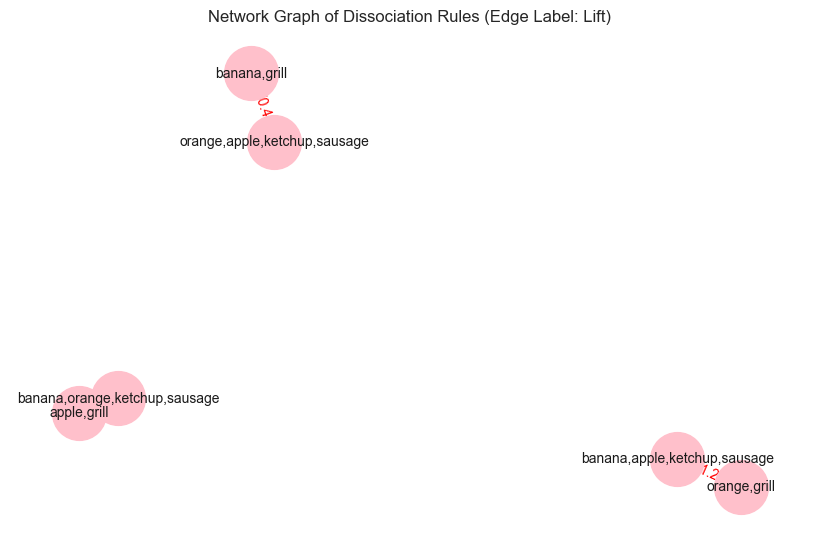

In [102]:
#directed graph
G = nx.DiGraph()
# adding edges for each rule
for i, rule in dissociation_rules.iterrows():
    G.add_edge(','.join(list(rule['antecedents'])), ','.join(list(rule['consequents'])), weight=rule['lift'])


plt.figure(figsize=(8, 5))
pos = nx.spring_layout(G, k=0.5, seed=42)  # Positioning of nodes
nx.draw(G, pos, with_labels=True, node_size=1500, node_color="pink", font_size=10, edge_color='gray')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()}, font_color='red')
plt.title('Network Graph of Dissociation Rules (Edge Label: Lift)')
plt.show()


----

### 3.2) Negative rules
The negative rules are the ones that have a low confidence between *X → Y*, meaning that if a pearson have bought iten *X* it is highly unlikely that they will also buy product *Y*, <br> so like in the example if person have bought the lactose free milk it is unlikely that the will also buy the 'normal' milk with the lactose.

So when we wanted to get the dissociation rules it was crucial to 'play with' support, now we have to play with the confidence.<br>
For that I have created the 'new basic' rules, where itemsets have to appear in at least 5% of the transactions and then adjusted the confidence and filtered out the ones where this confidence was really low to get the negative rules, so if a person bought product *X* it will be unlikely that they will also buy the product *Y*.

In [103]:
minSup = 0.05 #iteset has to appear in at least 5% of the transactions
frequent_itemsets_negative = apriori(basketdf, min_support=minSup, use_colnames=True)
# print(f"Number of frequent itemsets with min support of {minSup} is {frequent_itemsets_negative.shape[0]}")
# print(f"Here are the frequent itemsets:")
# print(frequent_itemsets_negative)

minConf = 0.0
zero_rules = association_rules(frequent_itemsets_negative, metric="confidence", min_threshold=minConf)
# print(f"Number of rules with min confidence of {minConf} is {rules.shape[0]}")
# print(f"The achieved rules:")
# zero_rules.sort_values(by='confidence', ascending=True)

#Now filtering the rules that are negative
negative_rules = zero_rules[(zero_rules['confidence'] < 0.15) & (zero_rules['lift'] < 0.9)]
negative_rules.sort_values(by='confidence', ascending=True)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
11,(milk),(banana),0.400313,0.165449,0.058455,0.146023,0.882590,-0.007776,0.977253,-0.181556
47,(milk),(orange),0.400313,0.162317,0.058455,0.146023,0.899617,-0.006523,0.980920,-0.156880


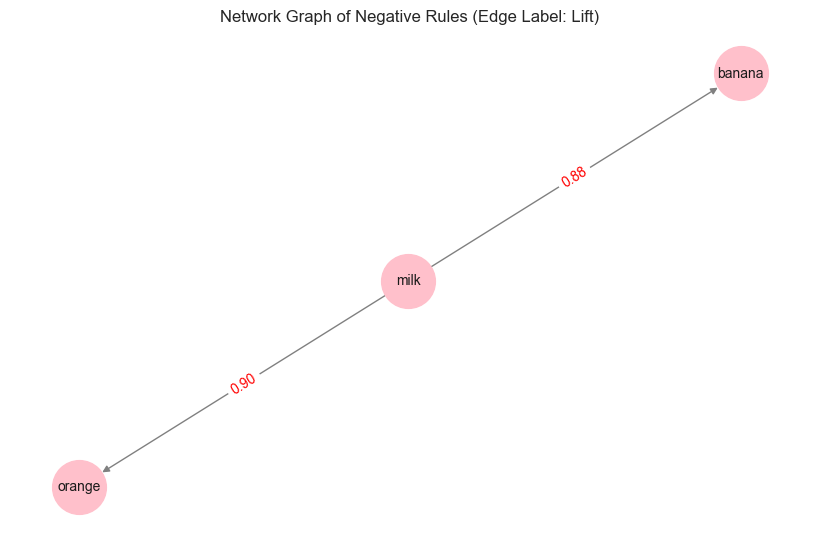

In [104]:
#directed graph
G = nx.DiGraph()
# adding edges for each rule
for i, rule in negative_rules.iterrows():
    G.add_edge(','.join(list(rule['antecedents'])), ','.join(list(rule['consequents'])), weight=rule['lift'])


plt.figure(figsize=(8, 5))
pos = nx.spring_layout(G, k=0.5, seed=42)  # Positioning of nodes
nx.draw(G, pos, with_labels=True, node_size=1500, node_color="pink", font_size=10, edge_color='gray')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()}, font_color='red')
plt.title('Network Graph of Negative Rules (Edge Label: Lift)')
plt.show()


------

### 3.3) Rules with disjunctions

First we wanted to 'connect' by xor every item but it was a very computationally expensive task and apriori could not manage this and fp growth took also tons of time, so it is easier to just do it 'manually' by just plotting it. Then we see the disjunctions in places when one node is connected to (at least) two other nodes that are not both connected

In [105]:
min_support = 0.05  # itemset must appear in at least 0.5% of the baskets
frequent_itemsets_for_disjunctions = apriori(basketdf, min_support=min_support, use_colnames=True) # Generate frequent itemsets with a low support base to get dissociation rules

minConf = 0.5 # for rule x -> y, confidence must be at least 90% so that y is likely to be bought if x is bought
rules_dis = association_rules(frequent_itemsets_for_disjunctions, metric="confidence", min_threshold=minConf)
rules_dist = rules_dis[rules_dis['lift'] > 1]

print(f"Number of rules using min confidence of {minConf} and min support of {min_support} is {rules_dis.shape[0]}")
rules_dis.sort_values(by='confidence', ascending=False)


Number of rules using min confidence of 0.5 and min support of 0.05 is 15


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
10,"(mustard, grill)",(sausage),0.057411,0.248434,0.057411,1.000000,4.025210,0.043148,inf,0.797342
11,"(mustard, sausage)",(grill),0.060543,0.113257,0.057411,0.948276,8.372795,0.050554,17.143702,0.937313
3,(grill),(sausage),0.113257,0.248434,0.105428,0.930876,3.746970,0.077291,10.872651,0.826753
4,(ketchup),(sausage),0.063152,0.248434,0.052192,0.826446,3.326620,0.036503,4.330450,0.746540
7,"(banana, orange)",(apple),0.062630,0.151879,0.051148,0.816667,5.377090,0.041636,4.626115,0.868415
8,"(banana, apple)",(orange),0.062630,0.162317,0.051148,0.816667,5.031297,0.040982,4.569178,0.854779
9,"(orange, apple)",(banana),0.063152,0.165449,0.051148,0.809917,4.895273,0.040700,4.390465,0.849360
6,(mustard),(sausage),0.080898,0.248434,0.060543,0.748387,3.012415,0.040445,2.986992,0.726840
1,(mustard),(grill),0.080898,0.113257,0.057411,0.709677,6.266092,0.048249,3.054338,0.914382
13,(mustard),"(grill, sausage)",0.080898,0.105428,0.057411,0.709677,6.731396,0.048882,3.081304,0.926385


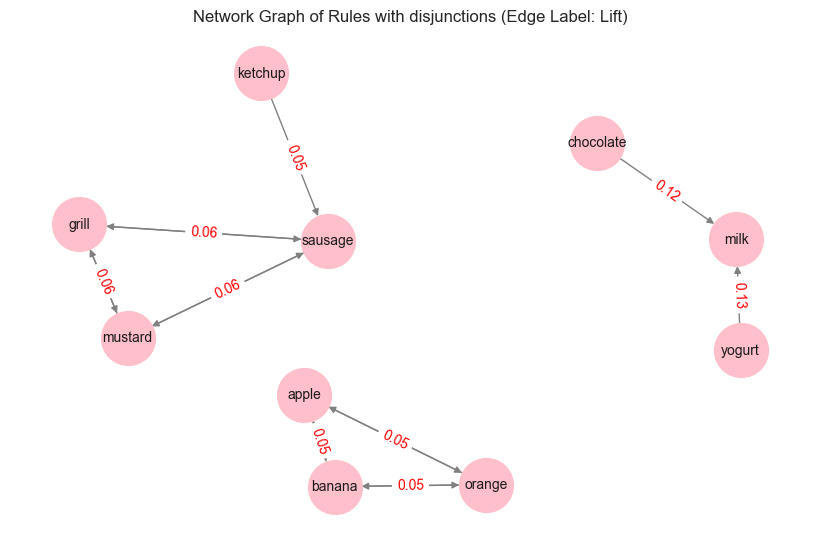

In [106]:
#directed graph
G = nx.DiGraph()
# adding edges for each rule
# for i, rule in rules_dis.iterrows():
#     G.add_edge(','.join(list(rule['antecedents'])), ','.join(list(rule['consequents'])), weight=rule['lift'])

for i, row in rules_dis.iterrows():
    antecedents = list(row['antecedents'])
    consequents = list(row['consequents'])
    
    for antecedent in antecedents:
        for consequent in consequents:
            G.add_edge(antecedent, consequent, weight=row['support'], confidence=row['confidence'])



plt.figure(figsize=(8, 5))
pos = nx.spring_layout(G, k=0.5, seed=42)  # Positioning of nodes
nx.draw(G, pos, with_labels=True, node_size=1500, node_color="pink", font_size=10, edge_color='gray')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()}, font_color='red')
plt.title('Network Graph of Rules with disjunctions (Edge Label: Lift)')
plt.show()


So here we see that we have 1 rule with XOR relationship and that is milk AND (chocolate XOR yogurt) since the milk is a node that is connected with two other - chocolate and yougurt and they are not connecetd with each other. We also see that we have similiar case with sausage, ketchup and grill or mustard.

------

### 3.4) Using statistical tests to check if the relations are strong

In the analysis, we wanted to evaluate the relationships between items in the dataset - if they are significant, by applying a chi-squared statistical test. To ensure the analysis focused on meaningful item combinations, we first chose the minimal support of 5% and later to 10% to see the changes in rule significance if we choose 'too big' min sup. <br>
We have also chosen a significance level of 0.05 (standard one, as we were thought at statistics classes) to determine whether the observed relationships between items were statistically significant by comparing it with relationships p_value. <br>
We began the analysis by generating all possible unique pairs of items in the dataset. For each pair, we calculated the observed support, which represents the proportion of transactions containing both items. Only pairs that met the specified minimum support threshold were included in the next steps to focus on relevant and frequent item combinations.<br>
For the qualifying pairs, we constructed a 2x2 contingency table that summarized the presence and absence of the two items across the dataset. Using this table, we performed a *chi-squared* statistical test to evaluate the independence of the items in the pair. The resulting *p-value* was compared to our chosen significance level of 0.05. If the *p-value* was smaller than 0.05, the relationship was considered statistically significant, indicating that the two items were likely dependent.

In [107]:
min_sup = 0.05  # Minimum support threshold
alpha = 0.05       # Significance level

def is_significant(min_sup, alpha):
    
    # extracting unique items to get individual items
    unique_items = basketdf.columns
    
    # generating all pairs of items
    item_pairs = combinations(unique_items, 2)
    
    results = []
    for item1, item2 in item_pairs:
        # Calculate observed support for both items together
        both_present = (basketdf[item1] & basketdf[item2]).sum()
        sup = both_present / len(basketdf)
    
        #we skip the pairs that don't meet minimum support
        if sup >= min_sup:
            # here we calculate the contingency table which is a 2x2 matrix that summarizes the relationship between two items
            contingency_table = [
                [(basketdf[item1] & basketdf[item2]).sum(), (basketdf[item1] & ~basketdf[item2]).sum()],
                [(~basketdf[item1] & basketdf[item2]).sum(), (~basketdf[item1] & ~basketdf[item2]).sum()]
            ]
    
            # chi-squared test
            chi2, pvalue, _, _ = chi2_contingency(contingency_table)
    
            results.append({
                'item1': item1,
                'item2': item2,
                'support': sup,
                'chi2_stat': chi2,
                'pvalue': pvalue,
                'significant': pvalue < alpha  # here we check if the relationship is significant -> so if the p-value is less than 0.05
            })
    
    results_df = pd.DataFrame(results)
    
    results_df = results_df.sort_values(by=['significant', 'chi2_stat'], ascending=[False, False])
    return results_df
    


In [108]:
min_sup = 0.05  # Minimum support threshold
alpha = 0.05       # Significance level
results_df_005 = is_significant(min_sup, alpha)    
print(f"Top Rules with Significant Relationships with minimal support of {min_sup}:")
print(f"Number of all relationships: {results_df_005.shape[0]}")
print(f"Number of significant relationships: {results_df_005[results_df_005['significant']].shape[0]}")
results_df_005

Top Rules with Significant Relationships with minimal support of 0.05:
Number of all relationships: 30
Number of significant relationships: 10


,item1,item2,support,chi2_stat,pvalue,significant
21,grill,sausage,0.105428,606.284507,7.192509e-134,True
20,grill,mustard,0.057411,590.881585,1.611210e-130,True
22,ketchup,sausage,0.052192,227.813723,1.787076e-51,True
27,mustard,sausage,0.060543,222.856362,2.154547e-50,True
3,apple,orange,0.063152,159.957880,1.155716e-36,True
0,apple,banana,0.062630,149.407968,2.335423e-34,True
19,chocolate,milk,0.122651,138.274322,6.347399e-32,True
6,banana,orange,0.062630,128.718508,7.815197e-30,True
26,milk,yogurt,0.129436,51.286207,7.983460e-13,True
15,chicken,milk,0.149791,11.023591,8.995964e-04,True


In [109]:
def plot_significance(results_df, min_sup):
    # here we count the number of significant and non-significant rules
    counts = results_df['significant'].value_counts()
    
    # assigning labels and colors
    labels = counts.index.map({True: 'Significant', False: 'Not Significant'})
    colours = counts.index.map({True: 'lightgreen', False: 'red'})
    
    plt.figure(figsize=(8, 6))
    counts.plot(kind='bar', color=colours)
    plt.title(f'Number of Significant and Non-Significant Rules with min support of {min_sup}')
    plt.xlabel('Significance')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=labels, rotation=0)
    plt.show()

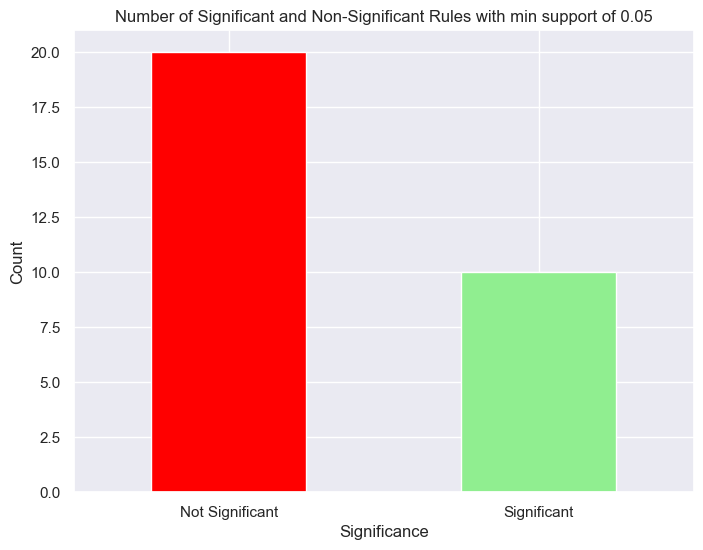

In [110]:
plot_significance(results_df_005, min_sup)

Here we see that with minimal support of 5% we get 30 rules from which only 10 are significant.

In [111]:
min_sup = 0.1  # Minimum support threshold
alpha = 0.05       # Significance level
results_df_01 = is_significant(min_sup, alpha)    
print(f"Top Rules with Significant Relationships with minimal support of {min_sup}:")
print(f"Number of all relationships: {results_df_01.shape[0]}")
print(f"Number of significant relationships: {results_df_01[results_df_01['significant']].shape[0]}")
results_df_01

Top Rules with Significant Relationships with minimal support of 0.1:


Number of all relationships: 6
Number of significant relationships: 4


,item1,item2,support,chi2_stat,pvalue,significant
4,grill,sausage,0.105428,606.284507,7.192509e-134,True
3,chocolate,milk,0.122651,138.274322,6.347399e-32,True
5,milk,yogurt,0.129436,51.286207,7.983460e-13,True
1,chicken,milk,0.149791,11.023591,8.995964e-04,True
0,bread,chicken,0.104384,0.176027,6.748102e-01,False
2,chicken,sausage,0.102296,0.160264,6.889133e-01,False


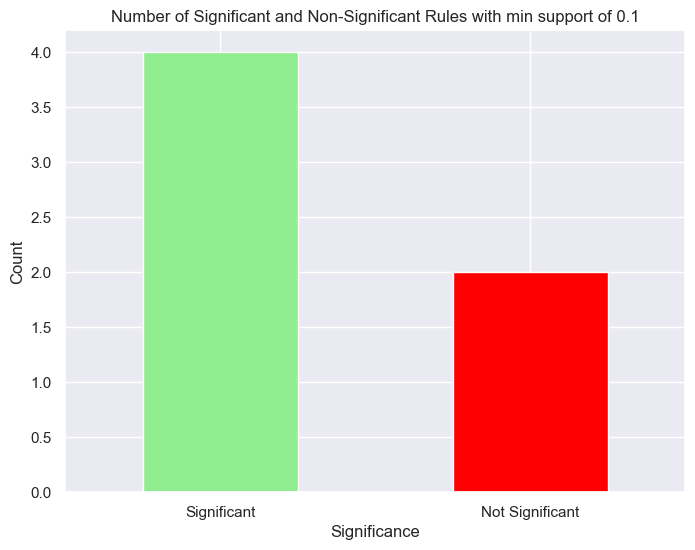

In [112]:
plot_significance(results_df_01, min_sup)

And when we choose the minimal support to be 10% we get 6 rules form which 4 are significant.

-----